# Code Snippets

__Description & purpose__: This Notebook is designed to showcase different tools and functions that are of scientific interest/use and implement the Earth Observation Data Hub. It provides a snapshot of the Hub, the `pyeodh` API client and the various datasets as of November 2024.   

__Author(s)__: Alastair Graham

__Date created__: 2024-11-08

__Date last modified__: 2024-11-08

__Licence__: This notebook is licensed under [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/).  The code is released using the [BSD-2-Clause](https://www.tldrlegal.com/license/bsd-2-clause-license-freebsd) license.


<span style="font-size:0.75em;">
Copyright (c) , All rights reserved.</span>

<span style="font-size:0.75em;">
Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:</span>

<span style="font-size:0.75em;">
Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.</span>

# Create data cube using sentinel2_ard STAC records

Users may have a need to generate a data cube directly from the CEDA Sentinel 2 Analysis Ready Data (ARD) (`sentinel2_ard`). As the STAC catalogue for that dataset has been created in a specific way, users will need to be aware of this and make alterations from the default. The following code was supplied by Pete Gadomski of Development Seed and enables the generation of a data cube from the ARD catalogue (as structured in November 2024). The STAC catalogue may be reprocessed in future to allow the default settings for `odc-stac` to be implemented.  

In [ ]:
# Note that this uses pystac and pystac_client

import os

import dask.distributed
import odc.stac
import rasterio
from pystac.extensions.raster import RasterBand
from pystac_client import Client

In [2]:
client = dask.distributed.Client()

In [3]:
client = Client.open("https://api.stac.ceda.ac.uk/")
item_collection = client.search(
    collections=["sentinel2_ard"],
    intersects={"type": "Point", "coordinates": [-1.3144, 51.5755]},
    sortby="-properties.datetime",
    max_items=10,
).item_collection()

# Commented out for clarity when submitted to training materials website.
# Uncomment the next line to view the Feature Collection

#item_collection

As of November 2024, the STAC items in `sentinel2_ard` are missing information because the projection and raster extensions are not installed. This means that `odc-stac` will refuse to compute the "geobox" and hence the subsequent components needed to generate and view the data cube. The code in the following cell adds those extensions.

In [ ]:
for item in item_collection.items:
    asset = item.assets["cog"]
    cog = rasterio.open(asset.href)
    epsg = cog.crs.to_epsg()
    dtypes = cog.dtypes
    shape = cog.shape
    transform = list(cog.transform)

    item.ext.add("proj")
    item.ext.add("raster")

    item.ext.proj.epsg = epsg

    cog = item.assets["cog"]
    cog.ext.raster.bands = [RasterBand.create(data_type=dtype) for dtype in dtypes]
    cog.ext.proj.shape = shape
    cog.ext.proj.transform = transform


In [8]:
bbox = [-1.2, 51.6, -1.1, 51.7]
dataset = odc.stac.load(item_collection, bands=("B03", "B04", "B08"), chunks={}, bbox=bbox)
dataset

<xarray.Dataset> Size: 48MB
Dimensions:      (y: 1121, x: 706, time: 10)
Coordinates:
  * y            (y) float64 9kB 2.005e+05 2.005e+05 ... 1.893e+05 1.893e+05
  * x            (x) float64 6kB 4.554e+05 4.554e+05 ... 4.624e+05 4.624e+05
    spatial_ref  int32 4B 27700
  * time         (time) datetime64[ns] 80B 2023-10-03T11:08:09 ... 2023-11-20...
Data variables:
    B03          (time, y, x) uint16 16MB dask.array<chunksize=(1, 1121, 706), meta=np.ndarray>
    B04          (time, y, x) uint16 16MB dask.array<chunksize=(1, 1121, 706), meta=np.ndarray>
    B08          (time, y, x) uint16 16MB dask.array<chunksize=(1, 1121, 706), meta=np.ndarray>

In [10]:
dataset.odc.geobox
dataset = dataset.compute()

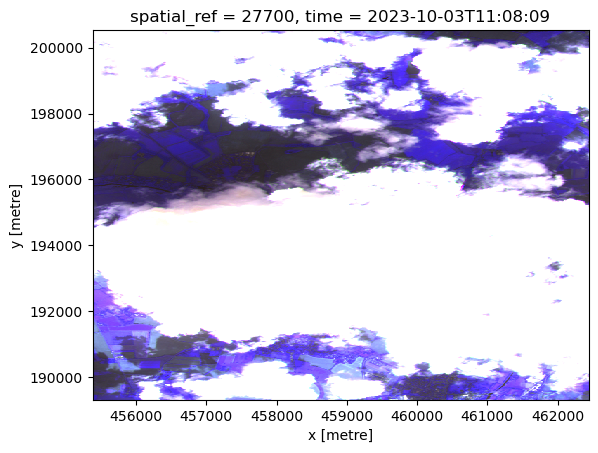

In [11]:
_ = dataset.isel(time=0).to_array("band").plot.imshow(vmin=0, vmax=256)